In [1]:
#from xgboost import XGBClassifier
import warnings
from tabpfn_new.scripts.transformer_prediction_interface import TabPFNClassifier
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from data_prep_utils import *
from evaluate import *
#from load_models import *
import matplotlib.pyplot as plt
import torch
import openml
from data_prep_utils import *
import matplotlib.pyplot as plt
from datetime import datetime
from tabpfn_new import priors, encoders
from tabpfn_new.scripts.model_configs import *
from tabpfn_new.scripts.model_builder import get_forest_prior_hyperparameters, get_mlp_prior_hyperparameters, get_model
from tabpfn.utils import get_uniform_single_eval_pos_sampler
from utils import get_dataloader
device = "cpu"

In [2]:
def reload_config(prior_type='forest', config_type='causal', task_type='binary', longer=0):
    config = get_prior_config(config_type=config_type)
    
    config['prior_type'] = prior_type
    
    model_string = ''
    
    config['epochs'] = 12000
    config['recompute_attn'] = True

    config['max_num_classes'] = 10
    config['num_classes'] = uniform_int_sampler_f(2, config['max_num_classes'])
    config['balanced'] = False
    model_string = model_string + '_multiclass'
    
    model_string = model_string + '_'+datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    
    return config, model_string

In [3]:
def dl_from_config(config_sample, prior_hyperparameters):
    def eval_pos_seq_len_sampler():
        single_eval_pos_gen = get_uniform_single_eval_pos_sampler(config.get('max_eval_pos', config['bptt']), min_len=config.get('min_eval_pos', 0))
        single_eval_pos = single_eval_pos_gen()
        return single_eval_pos, 1024
    dl_class, extra_kwargs = get_dataloader(config_sample, device="cpu", should_train=False, verbose=0)
    dl = dl_class(num_steps=1, batch_size=1, 
                                eval_pos_seq_len_sampler=eval_pos_seq_len_sampler, 
                                seq_len_maximum=None, device="cpu", **extra_kwargs)
    dl.model = None
    return dl

                                     
def get_sample(dl):
    (style, x, y), _, _ =  next(iter(dl))
    return x, y
    
def plot_grid(dl, hyperparameters, rows=8, cols=6, name=""):
    fig, axes = plt.subplots(rows, cols, figsize=(10,10), sharex=True, sharey=True, dpi=50)
    class_assigner = priors.flexible_categorical.BalancedBinarize()#priors.flexible_categorical.MulticlassRank(hyperparameters['num_classes'], ordered_p=hyperparameters['output_multiclass_ordered_p'])
    for ii, ax in enumerate(axes.flatten()):
        x2, b = get_sample(dl)
        x2 = np.array(x2)
        b = np.array(b)
        counts = np.unique(b, return_counts=True)[1]
        if counts[1]>counts[0]:
            b = -b+1
        #b = class_assigner(b)
        i1, i2 = np.random.choice(x2.shape[2], size=(2,), replace=False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(axis='both', which='major', labelsize=3)
        ax.set_xlim(0,np.max(x2[:1000, 0, i1])+1e-10)
        ax.set_ylim(0,np.max(x2[:1000, 0, i2])+1e-10)
        ax.scatter(x2[:1000, 0, i1], x2[:1000, 0, i2], c=b[:1000], s=2, alpha=0.75, cmap="bwr")
        if ii>rows*(cols-1)-1:
            ax.set_xlabel(f"x{ii-rows*(cols-1)+1}", fontsize=15)
        if ii%rows==0:
            ax.set_ylabel(f"x{ii//rows+1}", rotation=0, fontsize=15, labelpad=10)
    fig.suptitle(name.replace("_", " "), fontsize=25)
    fig.savefig(f"results/plots/featuregrid_{name}.png", bbox_inches="tight")

def remove_zero_features(x):
    x = x[:,:,torch.where(torch.sum(torch.abs(x), dim=0)>0,1,0)]
    return x

def plot_feature_combinations(dl, hyperparameters, num_plots=10):
    fig = plt.figure(figsize=(20,15))
    x2, b = get_sample(dl)
    #x2 = remove_zero_features(x2)
    #class_assigner = priors.flexible_categorical.BalancedBinarize()#MulticlassRank(hyperparameters['num_classes'], ordered_p=hyperparameters['output_multiclass_ordered_p'])
    #b = class_assigner(b)
    n_feat = num_plots#hyperparameters["max_features"]
    for i in range(n_feat-1):
        for j in range(n_feat):
            if(j>i) :
                ax = plt.subplot2grid((n_feat-1, n_feat-1), (i,j-1))
                #ax.xaxis.set_ticklabels([]) 
                #ax.yaxis.set_ticklabels([])
                plt.scatter(x2[:,0,i],x2[:,0,j],c=b, s=1.5, cmap="bwr")
    
    fig.show()

In [4]:
prior_type = 'mlp'
config, model_string = reload_config(prior_type, longer=1)

config['differentiable'] = True
config['flexible'] = True
config['bptt_extra_samples'] = None

# diff
config['output_multiclass_ordered_p'] = 0.0
del config['differentiable_hyperparameters']['output_multiclass_ordered_p']



config['sampling'] = 'normal' # vielleicht schlecht?
del config['differentiable_hyperparameters']['sampling']

config['pre_sample_causes'] = True
# end diff

config['multiclass_loss_type'] = 'nono' # 'compatible'
config['normalize_to_ranking'] = False # False

config['categorical_feature_p'] = 0 # diff: .0

# turn this back on in a random search!?
config['nan_prob_no_reason'] = .0
config['nan_prob_unknown_reason'] = .0 # diff: .0
config['set_value_to_nan'] = .0 # diff: 1.

config['normalize_with_sqrt'] = False

config['new_mlp_per_example'] = True
config['prior_mlp_scale_weights_sqrt'] = True
config['batch_size_per_gp_sample'] = None

config['normalize_ignore_label_too'] = False

config['differentiable_hps_as_style'] = False
config['max_eval_pos'] = 1000

config['random_feature_rotation'] = True
config['rotate_normalized_labels'] = True

config["mix_activations"] = True # False heisst eig True

config['n_layers'] = 4
config['emsize'] = 128
config['nhead'] = config['emsize'] // 32
config['bptt'] = 1024+128
config['canonical_y_encoder'] = True

    
config['aggregate_k_gradients'] = 1
config['batch_size'] = 1*config['aggregate_k_gradients']
config['num_steps'] = 1//config['aggregate_k_gradients']
config['epochs'] = 1

config['total_available_time_in_s'] = None #60*60*22 # 22 hours for some safety...

config['train_mixed_precision'] = True
config['efficient_eval_masking'] = True

# mlp params
config['is_causal'] = True
config['num_causes'] = 5
config['prior_mlp_hidden_dim'] = 50
config['num_layers'] = 4
config['noise_std'] = 0.05
config['init_std'] = 0.05
config['y_is_effect'] = True
config['pre_sample_weights'] = True
config['prior_mlp_dropout_prob'] = 0
config['pre_sample_causes'] = True
config["prior_mlp_activations"] = torch.nn.ReLU()
config["block_wise_dropout"] = True
config["sort_features"] = False
config["in_clique"] = False

# general data params
config['balanced'] = True
config['max_num_classes'] = 2
config['max_features'] = 100
config['num_features_used'] = 100

config['num_classes'] = 2

config['no_encoder'] = False
config['normalize_to_ranking'] = False # False
config['normalize_with_sqrt'] = False
config['normalize_ignore_label_too'] = False
config["normalize"] = False
config['num_classes'] = 2
config["balanced"] = False
config['multiclass_type'] = 'imbalanced_binarize'


config_sample = evaluate_hypers(config)



In [ ]:
#dl = dl_from_config(config_sample, prior_hyperparameters)
model = get_model(config_sample, device, should_train=False, verbose=0)
dl = model[3]

In [ ]:
plot_grid(dl,config_sample)

In [ ]:
plot_feature_combinations(dl,config_sample)

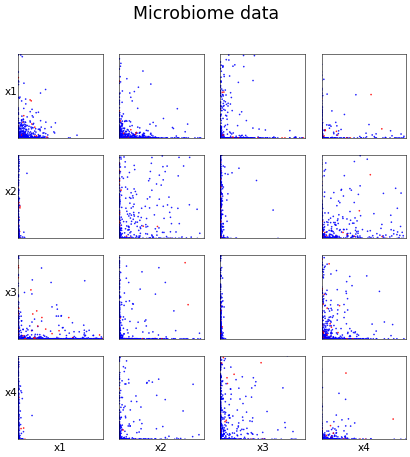

In [16]:
from torch.utils.data import DataLoader
class MicroDL(DataLoader):
    def __init__(self, path=None):
        data, labels = get_microbiome(path)
        data = top_non_zero(data)
        #data = data[:,np.random.choice(np.arange(data.shape[1]),size=100)]
        data, labels = unison_shuffled_copies(data, labels)
        self.data = data
        self.labels = labels

    def __len__(self):
        return 100
        
    def get_perm(self):
        indices = np.random.permutation(self.data.shape[0])[:1000]
        return (None, np.expand_dims(self.data[indices], axis=1), np.expand_dims(self.labels[indices],axis=1)), None, None
        
    def __iter__(self):
        indices = np.random.permutation(self.data.shape[0])[:1000]
        return iter(self.get_perm() for _ in range(100))
path = "datasets/data_all.csv"
dl1 = MicroDL(path)
plot_grid(dl1, config_sample, 4,4, "Microbiome_data")
#plot_feature_combinations(dl1, config_sample)

In [7]:
prior_type = 'mlp'
config, model_string = reload_config(prior_type, longer=1)

config['differentiable'] = True
config['flexible'] = True
config['bptt_extra_samples'] = None

# diff
config['output_multiclass_ordered_p'] = 0.0
del config['differentiable_hyperparameters']['output_multiclass_ordered_p']



config['sampling'] = 'normal' # vielleicht schlecht?
del config['differentiable_hyperparameters']['sampling']

config['pre_sample_causes'] = True
# end diff

config['multiclass_loss_type'] = 'nono' # 'compatible'

config['categorical_feature_p'] = 0 # diff: .0

# turn this back on in a random search!?
config['nan_prob_no_reason'] = .0
config['nan_prob_unknown_reason'] = .0 # diff: .0
config['set_value_to_nan'] = .0 # diff: 1.


config['new_mlp_per_example'] = True
config['prior_mlp_scale_weights_sqrt'] = True
config['batch_size_per_gp_sample'] = None



config['differentiable_hps_as_style'] = False
config['max_eval_pos'] = 1025
config['min_eval_pos'] = 1024

config['random_feature_rotation'] = True
config['rotate_normalized_labels'] = True

config["mix_activations"] = True # False heisst eig True

config['n_layers'] = 2
config['emsize'] = 64
config['nhead'] = config['emsize'] // 16
config['bptt'] = 1024+128+5000
config['canonical_y_encoder'] = False


config['total_available_time_in_s'] = None #60*60*22 # 22 hours for some safety...

config['train_mixed_precision'] = False
config['efficient_eval_masking'] = True

# mlp params
config['is_causal'] = False # False for data from MLP input
config['num_causes'] = 5
config['prior_mlp_hidden_dim'] = 50
config['num_layers'] = 4
config['noise_std'] = 0.05
config['init_std'] = 0.05
config['y_is_effect'] = True
config['pre_sample_weights'] = True
config['prior_mlp_dropout_prob'] = 0
config['pre_sample_causes'] = True
config["prior_mlp_activations"] = torch.nn.ReLU
config["block_wise_dropout"] = True
config["sort_features"] = False
config["in_clique"] = False

# general data params
config['balanced'] = True
config['max_features'] = 1000
config['num_features_used'] = 1000
config['num_features'] = 1000

config['differentiable'] = True
config['flexible'] = True

# forest params
config["min_features"] = 1000
config["max_features"] = 1000
config["n_samples"] = 1000
config["base_size"] = 1000
config["n_estimators"] = 1
config["categorical_x"] = False
config["comp"] = False

config['no_encoder'] = False
config['normalize_to_ranking'] = False # False
config['normalize_with_sqrt'] = False
config['normalize_ignore_label_too'] = False
config["normalize_labels"] = False
config["normalize"] = False
config["clr"] = False
config["num_classes"] = 2
config["max_num_classes"] = 2

# forest params
config["min_depth"] = 5
config["max_depth"] = 10
config["data_sample_func"] = "mnd"

# mlp params
config["mlp_noise"] = False # needs to be false such that noise doesn't get drown out information from input to final output
config["sampling"] = "mnd"
if "is_causal" in config['differentiable_hyperparameters']:
    del config['differentiable_hyperparameters']['is_causal']
config["is_causal"] = False # needs to be false such that mnd causes are x
if "block_wise_dropout" in config['differentiable_hyperparameters']:
    del config['differentiable_hyperparameters']['block_wise_dropout']
config["block_wise_dropout"] = False # needs to be false for final output = y, otherwise setting last-layer block to dropout creates bad datasets
# increase lower bound of hidden dim for more complex datasets
config['differentiable_hyperparameters']["prior_mlp_hidden_dim"] = {'distribution': 'meta_gamma', 'max_alpha': 3, 'max_scale': 100, 'round': True, 'lower_bound': 25} 

# general data params
config["prior_type"] = "mlp"
config['multiclass_type'] = 'fixed_balance'
del config['differentiable_hyperparameters']['multiclass_type']
config["align_majority"] = False
config["limit_imbalance"] = False
config["microbiome_test"] = True
config["weight_classes"] = False

# training params
config['aggregate_k_gradients'] = 1
config['batch_size'] = 1*config['aggregate_k_gradients']
config['num_steps'] = 1*config['aggregate_k_gradients']//config['aggregate_k_gradients']
config['epochs'] = 10
config["lr"] = 1e-2
config["frac"] = 0.95
#config['warmup_epochs'] = 10

config["run_name"] = "time"

config_sample = evaluate_hypers(config)

In [20]:
config["mnd_M"] = 1000
config["mnd_noise"] = 0
config["alpha_bound"] = 0
config["a1a2_bound"] = 0
config["mnd_a1_l"] = 0.025
config["mnd_a1_h"] = 0.75
config["mnd_a2_l"] = 3
config["mnd_a2_h"] = 10
config_sample = evaluate_hypers(config)
model = get_model(config_sample, device, should_train=False, verbose=0)
dl2 = model[3]
all_data,labels = get_sample(dl2)
print(all_data.shape, labels.shape)
all_data = all_data[:,0,:]#.numpy().astype(float)
labels = labels[:,0]#.numpy().astype(int)
#np.save("results/dimred_dm_data.npy", all_data )
#np.save("results/dimred_dm_labels.npy", labels )

torch.Size([6152, 1, 1000]) torch.Size([6152, 1])


0.0


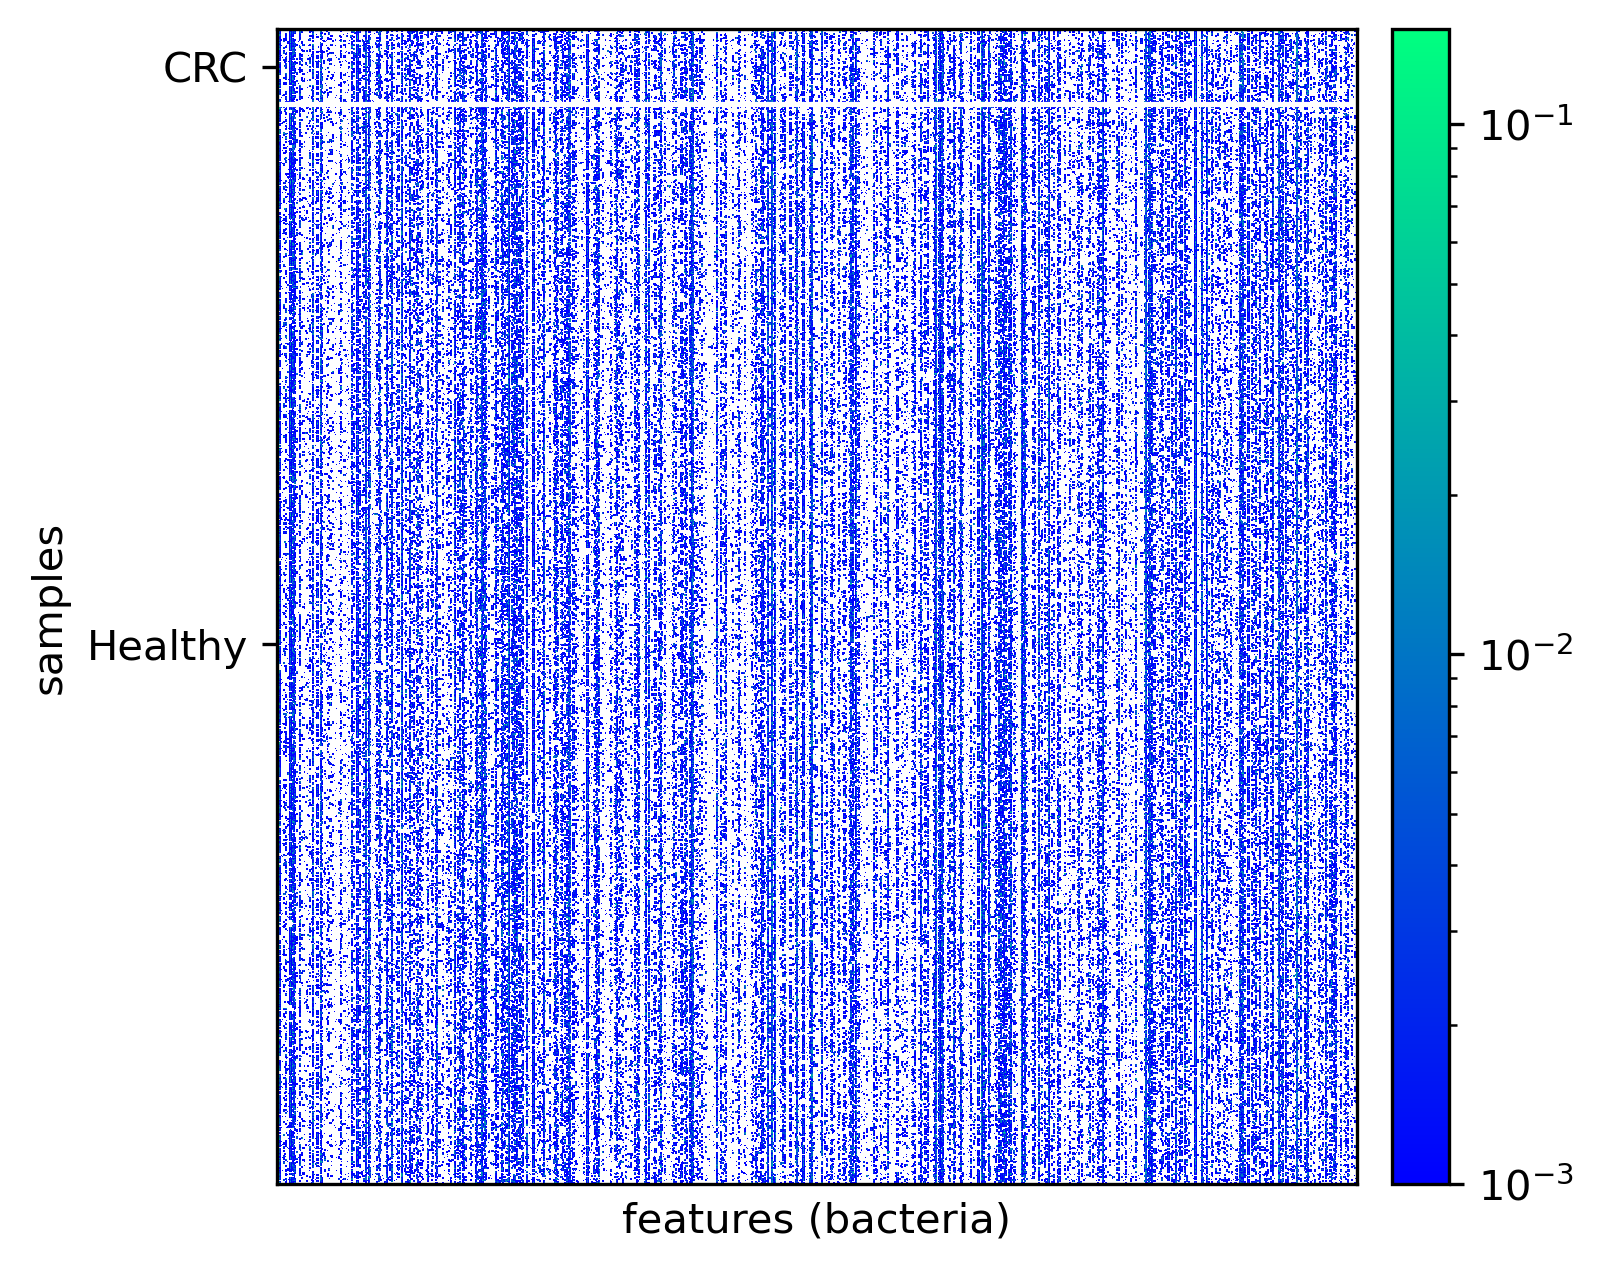

In [21]:

import matplotlib.colors as colors
all_data = np.array(all_data)
labels = np.array(labels)
le1 = 1000
le2 = 70
wd = all_data.shape[1]
counts = np.count_nonzero(all_data, axis=0)
counts = np.mean(all_data, axis=0)
indices = np.argsort(counts)[::-1]
data = all_data#[:,indices]
data_c0 = data[labels==0]
np.random.shuffle(data_c0)
data_c1 = data[labels==1]
np.random.shuffle(data_c1)
data = np.concatenate((data_c0[:le1], data_c1[:le2]), axis=0)
print(np.min(data))
'''for c in ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
                      'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
                      'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper']+['viridis', 'plasma', 'inferno', 'magma', 'cividis']+['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']:'''

plt.figure(figsize=(15,5), dpi=300)
plt.imshow(data[:le1+le2,:wd], norm=colors.LogNorm(), cmap="winter", origin="lower", aspect="equal")
plt.plot(np.arange(wd), np.ones(wd)*le1, c="white", lw=1.25)
y_pos = 515
x_pos = 75
x_len = 100
y_len = 40
#plt.arrow(x=x_pos+x_len, y=y_pos+y_len, dx=-x_len, dy=-y_len, color="red", width=5,head_width=20)
y_pos = 515
x_pos = 1250
x_len = -100
y_len = 40
#plt.arrow(x=x_pos+x_len, y=y_pos+y_len, dx=-x_len, dy=-y_len, color="red", width=5,head_width=20)
plt.ylabel("samples")
plt.xlabel("features (bacteria)")
plt.yticks([int(le1/2),le1+int(le2/2)], ["Healthy", "CRC"])
plt.xticks([])
plt.colorbar(pad=.01)
if not os.path.exists("results/plots"):
    os.makedirs("results/plots")
plt.savefig("results/plots/mb_dataset_overview_defense_dm.eps", bbox_inches="tight")
plt.show()

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\lenna\anaconda3\envs\master7\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lenna\anaconda3\envs\master7\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\lenna\anaconda3\envs\master7\Lib\subprocess.py", line

<Figure size 250x250 with 0 Axes>

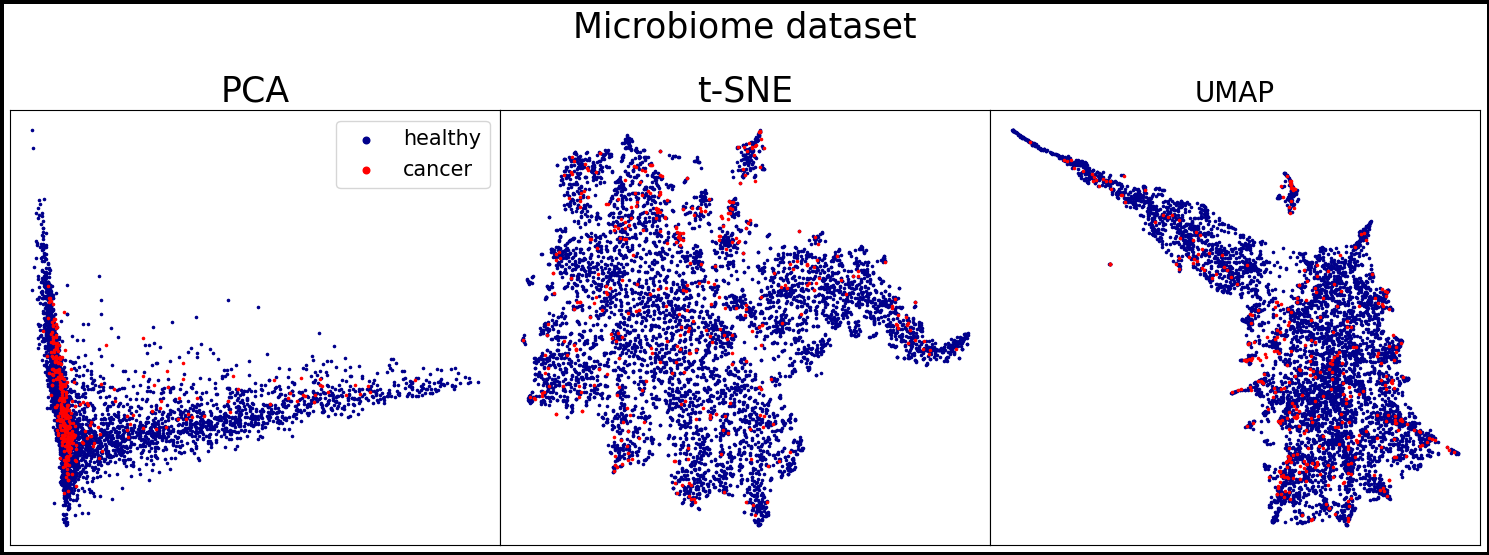

<Figure size 250x250 with 0 Axes>

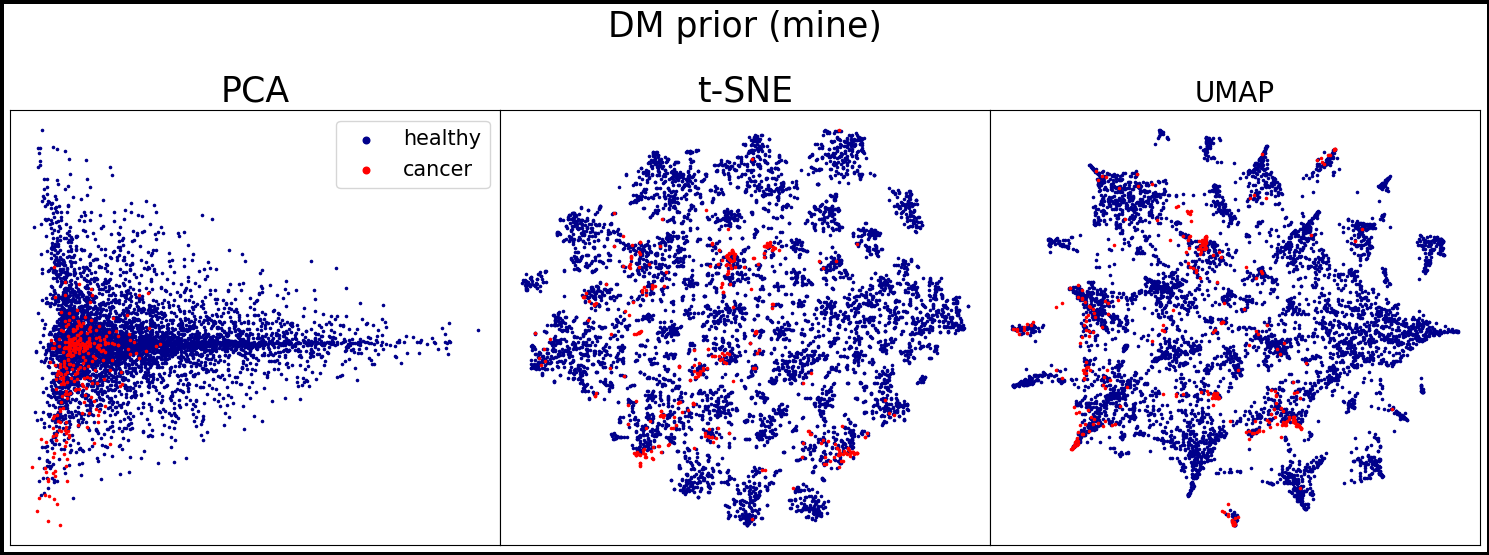

<Figure size 250x250 with 0 Axes>

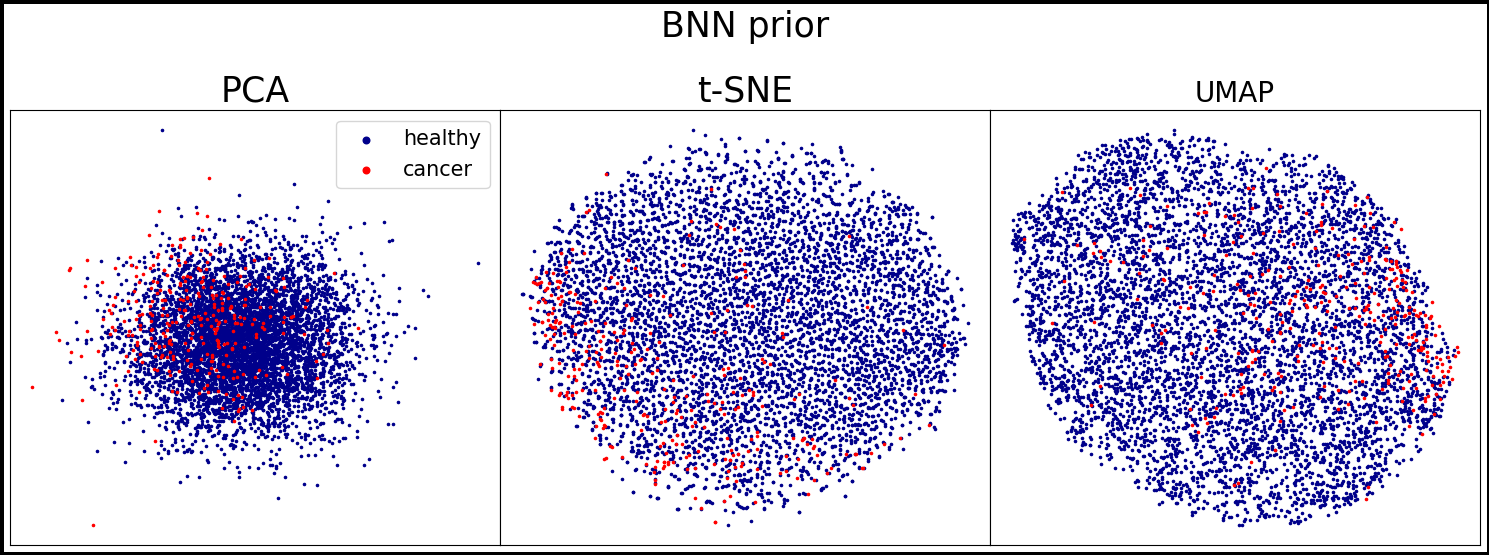

In [4]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import umap
import matplotlib.pyplot as plt

titles = ["Microbiome dataset", "DM prior (mine)", "BNN prior"]
names = ["mb", "dm", "normal"]
for ii,n in enumerate(names):
    all_data = np.load(f"results/dimred_{n}_data.npy")
    labels = np.load(f"results/dimred_{n}_labels.npy")
    all_data = all_data#+1e-10
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(all_data)
    pca_data_c0 = pca_data[labels==0]
    pca_data_c1 = pca_data[labels==1]
    
    tsne = TSNE(n_components=2)
    tsne_data = tsne.fit_transform(all_data)
    tsne_data_c0 = tsne_data[labels==0]
    tsne_data_c1 = tsne_data[labels==1]
    
    umap_d = umap.UMAP(n_components=2)
    umap_data = umap_d.fit_transform(all_data)
    umap_data_c0 = umap_data[labels==0]
    umap_data_c1 = umap_data[labels==1]
    size = 10
    c1 = "darkblue"
    c2 = "red"
    a1 = 1.0
    a2 = 1.0
    m1 = "."
    m2 = "."
    
    plt.figure(figsize=(5,5), dpi=50)
    fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw={'wspace': 0}, figsize=(15, 5))
    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('black')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    
    # First subplot
    ax[0].scatter(pca_data_c0[:,0],pca_data_c0[:,1],alpha=a1,s=size, c=c1, label="healthy", marker=m1)
    ax[0].scatter(pca_data_c1[:,0],pca_data_c1[:,1],alpha=a2, s=size, c=c2, label="cancer", marker=m2)
    ax[0].set_title('PCA', fontsize=25)
    
    # Second subplot
    ax[1].scatter(tsne_data_c0[:,0],tsne_data_c0[:,1],alpha=a1, s=size, c=c1, label="healthy", marker=m1)
    ax[1].scatter(tsne_data_c1[:,0],tsne_data_c1[:,1],alpha=a2, s=size, c=c2, label="cancer", marker=m2)
    ax[1].set_title('t-SNE', fontsize=25)
    
    # Third subplot
    ax[2].scatter(umap_data_c0[:,0],umap_data_c0[:,1],alpha=a1, s=size, c=c1, label="healthy", marker=m1)
    ax[2].scatter(umap_data_c1[:,0],umap_data_c1[:,1],alpha=a2, s=size, c=c2, label="cancer", marker=m2)
    ax[2].set_title('UMAP', fontsize=20)
    
    ax[0].legend(loc="upper right", markerscale=3.0, fontsize=15)
    # Display the plots
    plt.tight_layout()  # Optional, to prevent overlapping of subplots
    plt.suptitle(titles[ii], y=1.1, fontsize=25)
    plt.savefig(f"results/plots/{n}prior_dimreds.png", bbox_inches="tight", edgecolor=fig.get_edgecolor())
    plt.show()

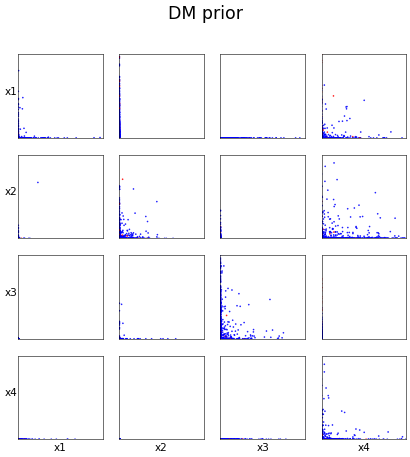

In [14]:
row, col = 4, 4
config["mnd_M"] = 1000
config["mnd_noise"] = 0
config["alpha_bound"] = 0
config["a1a2_bound"] = 0
config["mnd_a1_l"] = 0.025
config["mnd_a1_h"] = 0.5
config["mnd_a2_l"] = 3
config["mnd_a2_h"] = 10
config_sample = evaluate_hypers(config)
model = get_model(config_sample, device, should_train=False, verbose=0)
dl2 = model[3]
x1,labels = get_sample(dl2)
plot_grid(dl2, config_sample, row, col, "DM_prior")

In [ ]:
import scipy
bs = [[0.5,1],[1,10],[2,5],[0.1,5], [5,1]]
fig, axs = plt.subplots(1, len(bs), figsize=(len(bs)*3, 3))
x = np.linspace(0.01,1,100)
for ii, b in enumerate(bs):
    y = scipy.stats.beta.pdf(x,*b)
    maxy =  np.max(y)
    axs[ii].set_xlim(0, 1)  # Set x-axis limits
    axs[ii].set_ylim(0, maxy)  # Set x-axis limits
    axs[ii].set_xticks([0,0.5,1])  # Set x-axis ticks
    axs[ii].set_yticks([0,round(0.5*maxy * 2) / 2,round(maxy * 2)/2])  # Set x-axis ticks
    #axs[ii].set_yticks(y_ticks1)
    axs[ii].set(adjustable='box')#, aspect='equal')
    axs[ii].set_title(r"$\beta_1$="+str(b[0])+ r"   $\beta_2$="+str(b[1]), fontsize=20)
    axs[ii].plot(x, y, linewidth=2, c="navy")
fig.tight_layout()
plt.show()
fig.savefig("results/beta.eps")

In [ ]:
import scipy
b1s = [0.25,0.5,0.75]
b2s = [1,5,10]
fig, axs = plt.subplots(len(b1s), len(b2s), figsize=(15,9),sharex=True, sharey=True)#(len(b1s)*3, len(b2s)*3))
x = np.linspace(0.01,1,100)
for ii, b1 in enumerate(b1s):
    for jj, b2 in enumerate(b2s):
        y = scipy.stats.beta.pdf(x,b1,b2)
        maxy =  np.max(y)
        axs[ii,jj].tick_params(axis='both', which='major', labelsize=10)
        axs[ii,jj].set_xlim(0.01, 1)  # Set x-axis limits
        axs[ii,jj].set_ylim(0, 15)  # Set x-axis limits
        axs[ii,jj].set_xticks([0,0.5,1])  # Set x-axis ticks
        axs[ii,jj].set_yticks([0,7.5,15])  # Set x-axis ticks
        #axs[ii,jj].set_yticks([0,round(0.5*maxy * 2) / 2,round(maxy * 2)/2])  # Set x-axis ticks
        #axs[ii].set_yticks(y_ticks1)
        axs[ii,jj].set(adjustable='box')#, aspect='equal')
        axs[ii,jj].set_title(r"$\beta_1$="+str(b1)+ r"   $\beta_2$="+str(b2), fontsize=15)
        axs[ii,jj].plot(x, y, linewidth=2, c="navy")
fig.suptitle("Beta distribution for various parameters", fontsize=22)
fig.tight_layout()
plt.show()
fig.savefig("results/beta.eps")

In [ ]:

x1,labels = get_sample(dl1)
#x1 = top_anova(x1[:,0,:],labels)
bins = np.linspace(0,1,51)#100#np.geomspace(1e-10,1e-1,50)
print(bins)
fig, ax = plt.subplots(2, 2, figsize=(30,15),sharex=True, sharey=True)
ax[0,0].set_title("Original data", fontsize=40)
ax[0,0].hist(torch.flatten(torch.tensor(x1)),bins=bins, rwidth=0.75,align="right", density=False,color="navy")
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0,1)
ax[0,0].set_ylabel("counts", fontsize=35)
ax[0,0].set_xlabel("relative abundancies", fontsize=35)
ax[0,0].set_xticks([0,0.3,0.6,0.9])#10**(np.arange(6)))
ax[0,0].set_yticks([])#10**(np.arange(6)))
ax[0,0].tick_params(axis='both', which='major', labelsize=30)    
for axis in ['top','bottom','left','right']:
    ax[0,0].spines[axis].set_linewidth(3)
#ax[0].tick_params(axis='both', which='minor', labelsize=8)
values = []
b1 = np.random.uniform(0.025,0.5,100)
b2 = np.random.uniform(3,10,100)
alphabeta = np.random.beta(b1,b2)
alpha3 = np.abs(np.random.normal(0,1,size=100))#np.random.rand(100)*1e-1
alpha4 = np.ones(100)*1e-3#np.random.gamma(0.1,1,size=100)#np.abs(np.random.normal(0,0.25,size=100))#np.random.rand(100)*1e-2
alpha2 = np.random.rand(100)*0.01
alphas = [alpha2, alphabeta, alpha3, alpha4]
names = ["Original data", r"$|\alpha_k| \sim \mathcal{N}(0,1)$", r"$DMP: \alpha_k \sim \mathrm{Beta}_k(\beta^{(1)},\beta^{(2)})\quad \beta^{(i)}\sim\mathrm{U}^{(i)}$", r"$\alpha_k \sim \mathrm{U}(0,0.01)$"]
for i in range(1,4):
    #alpha = np.random.rand(100)*10**(2-i)
    #alpha = np.ones(100)*10**(2-i)
    alpha = alphas[i-1]
    print(i//2,i%2)
    thetas = np.random.dirichlet(alpha, size=1000)
    
    ax[i//2,i%2].set_xlabel(r"probabilities $\theta_k$", fontsize=35)
    ax[i//2,i%2].set_ylabel("counts", fontsize=35)
    ax[i//2,i%2].set_title(names[i], fontsize=40)
    #ax[i//2,i%2].hist(torch.flatten(torch.tensor(thetas)),bins=bins, rwidth=0.75,align="mid", histtype="step", density=False,color="black")
    ax[i//2,i%2].hist(torch.flatten(torch.tensor(thetas)),bins=bins, rwidth=0.75,align="mid", histtype="bar", density=False,color="dimgrey")
    ax[i//2,i%2].set_xlim(0,1)
    
    for axis in ['top','bottom','left','right']:
        ax[i//2,i%2].spines[axis].set_linewidth(3)
    ax[i//2,i%2].tick_params(axis='both', which='major', labelsize=30)
    ax[i//2,i%2].set_yscale('log')
    #ax[i].set_yticks([], major=False, minor=False)#10**(np.arange(6)))
#fig.suptitle(r"Abundancies in dataset compared to various sampling methods for $\boldsymbol{\alpha}$", fontsize=15)
fig.tight_layout()
plt.show()
fig.savefig("results/betacompare.eps")

In [ ]:
import mpltern

from mpltern.datasets import get_dirichlet_pdfs
import scipy
fig = plt.figure(figsize=(10.8, 8.8))
fig.subplots_adjust(
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.5,
    hspace=0.5,
)
grid_size = 100
a_vals = np.linspace(0.01, 1, grid_size)
b_vals = np.linspace(0.01, 1, grid_size)

A, B = np.meshgrid(a_vals, b_vals)
C = 1 - A - B

# Filter out points where A + B + C = 1 (inside the simplex)
mask = (A + B) < 1-1e-3
A = A[mask]
B = B[mask]
C = C[mask]
alphas = ((0.3, 0.3, 0.3), (5.0, 5.0, 5.0), (1.0, 10.0, 2.0), (2.0, 4.0, 8.0))
for i, alpha in enumerate(alphas):
    ax = fig.add_subplot(2, 2, i + 1, projection="ternary")
    v = scipy.stats.dirichlet.pdf(np.stack([A, B, C], axis=-1).T, alpha)
    cmap = "Blues"
    shading = "gouraud"
    cs = ax.tripcolor(A, B, C, v, cmap=cmap, shading=shading, rasterized=True)
    ax.tricontour(A, B, C, v, colors="k", linewidths=0.5)

    ax.set_tlabel(r"$\theta_1$")
    ax.set_llabel(r"$\theta_2$")
    ax.set_rlabel(r"$\theta_3$")

    ax.taxis.set_label_position("tick1")
    ax.laxis.set_label_position("tick1")
    ax.raxis.set_label_position("tick1")

    ax.set_title("${\\mathbf{\\alpha}}$ = " + str(alpha))

    cax = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
    colorbar = fig.colorbar(cs, cax=cax)
    colorbar.set_label("PDF", rotation=270, va="baseline")

plt.show()

In [ ]:
config_sample = evaluate_hypers(config)
model = get_model(config_sample, device, should_train=False, verbose=0)
dl2 = model[3]
x, y = get_sample(dl2)
plot_grid(dl2, config_sample)
plot_feature_combinations(dl2, config_sample)

In [ ]:
config["data_sample_func"] = "mnd"


config_sample = evaluate_hypers(config)
model = get_model(config_sample, device, should_train=False, verbose=0)
dl = model[3]

In [ ]:
plot_grid(dl, config_sample)
plot_feature_combinations(dl, config_sample)

In [ ]:
from tabpfn import TabPFNClassifier
model = TabPFNClassifier(device='cpu', N_ensemble_configurations=1)
x, y = get_sample(dl)
x, y = torch.squeeze(x), torch.squeeze(y)
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(torch.tensor(preds)*y_test+(torch.tensor(preds)-1)*(y_test-1))

In [ ]:
config['differentiable'] = True
config['flexible'] = True
config["prior_type"] = "forest"
config["sampling"] = "mnd"
#del config['differentiable_hyperparameters']['sampling']
config["data_sample_func"] = "mnd"
config["is_causal"] = False
#del config['differentiable_hyperparameters']['is_causal']
config['multiclass_type'] = 'balance'
config['hist_targets'] = False

config["align_majority"] = False
config["limit_imbalance"] = False

config["normalize"] = True
config["num_classes"] = 2
config["max_num_classes"] = 2

config['min_depth'] = 5
config['max_depth'] = 15
#del config['differentiable_hyperparameters']['multiclass_type']

config_sample = evaluate_hypers(config)
model = get_model(config_sample, device, should_train=False, verbose=0)
dl = model[3]

In [ ]:
for i in range(100):
    print(f"\n\n\nRun #{i}")
    x, y = get_sample(dl)
    x, y = torch.squeeze(x), torch.squeeze(y)
    print("Target mean: ", torch.mean(y))
    if len(np.unique(y, return_counts=True)[0])>1 and np.min(np.unique(y, return_counts=True)[1])>20:
        #plt.hist(y, bins=100)
        #plt.show()
        cv = 3
        n_optim = 20
        ft_epochs = 0
        sampling = None
        strat_split=True
        max_samples = 1000
        metrics = metrics = ["accuracy", "precision", "recall", "roc_auc"]
        models = [
            #XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
            XGBoostOptim(n_optim=n_optim),
            #LogisticRegression(max_iter=500), 
            #TabPFNClassifier(device='cpu', N_ensemble_configurations=3),
            #TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml")
        ]
        results = pd.DataFrame(np.zeros((len(models), len(metrics))), 
                               index=[m.__class__.__name__ for m in models],
                              columns=metrics)
        
        for ii, model in enumerate(models):
            results.iloc[ii,:] = cross_validate_sample(model, x, y, metrics, strat_split, cv, sampling)
        print(results)

In [ ]:
config['differentiable'] = True
config['flexible'] = True
config["prior_type"] = "mlp"
config["sampling"] = "mnd"
#del config['differentiable_hyperparameters']['sampling']
config["data_sample_func"] = "mnd"

config['multiclass_type'] = 'balance'
config["is_causal"] = False
if "is_causal" in config['differentiable_hyperparameters']:
    del config['differentiable_hyperparameters']['is_causal']
if 'multiclass_type' in config['differentiable_hyperparameters']:
    del config['differentiable_hyperparameters']['multiclass_type']

if "block_wise_dropout" in config['differentiable_hyperparameters']:
    del config['differentiable_hyperparameters']['block_wise_dropout']
config["block_wise_dropout"] = False



config['hist_targets'] = False
config['y_std'] = 1
config['min_depth'] = 5
config['max_depth'] = 15
config['num_classes'] = 2
config["max_num_classes"] = 2


config["align_majority"] = False
config["limit_imbalance"] = False
config["verbose"] = True

config["mlp_noise"] = True
for scale in [3,1,0.1]:
    
    config['differentiable_hyperparameters']['noise_std'] = {'distribution': 'uniform', 'min': 0.001, 'max': 0.0001}#{'distribution': 'meta_trunc_norm_log_scaled', 'max_mean': 0.0001, 'min_mean': 0.00001, 'round': False, 'lower_bound': 0.0}
    config['differentiable_hyperparameters']["prior_mlp_dropout_prob"] = {'distribution': 'uniform', 'min': 0.1, 'max': 0.5} #{'distribution': 'meta_beta', 'scale': scale, 'min': 0.01, 'max': 0.1}
    config['differentiable_hyperparameters']["prior_mlp_hidden_dim"] = {'distribution': 'uniform_int', 'min': 10, 'max': 50}#{'distribution': 'meta_gamma', 'max_alpha': 3, 'max_scale': 100, 'round': True, 'lower_bound': 25}
    config['differentiable_hyperparameters']["num_layers"] = {'distribution': 'uniform_int', 'min': 3, 'max': 5}
    #config["epoch_frac"] = e/maxepo
    config_sample = evaluate_hypers(config)
    model = get_model(config_sample, device, should_train=False, verbose=2)
    dl = model[3]
    rocs = []
    means = []
    for i in range(100):
        #print(f"\n\n\nRun #{i}")
        x, y = get_sample(dl)
        x, y = torch.squeeze(x).numpy(), torch.squeeze(y).numpy()
        #print((x[:,np.sum(np.abs(x), axis=0)==0]).shape)
        #print(np.unique(y, return_counts=True))
        #if len(np.unique(y, return_counts=True)[0])<2: print("HERE FUZCKSNDKSHFKHSFG!!!!!!!!!###########################################################################################################################################\n\n")
        means.append(np.mean(y))
        if len(np.unique(y, return_counts=True)[0])>1 and np.min(np.unique(y, return_counts=True)[1])>1:
            #print("Target mean: ", torch.mean(y))
            #plt.hist(y, bins=100)
            #plt.show()
            cv = 3
            n_optim = 100
            ft_epochs = 0
            sampling = None
            strat_split=True
            max_samples = 1024
            metrics = metrics = ["roc_auc"]#"roc_auc_ovr"]
            if config['num_classes'] ==2:
                o = 'binary:logistic'
            else:
                o = 'multi:softmax'
            #model = XGBClassifier(n_estimators=10, max_depth=10, learning_rate=1, objective=o)#
            #model = XGBoostOptim(n_optim=n_optim)
            model = TabPFNClassifier(device='cpu', N_ensemble_configurations=3)
            results,_ = cross_validate_sample(model, x, y, metrics, strat_split, cv, sampling, max_samples=max_samples)
            #print(results[0])
            rocs.append(results[0])
            print("ROC: ", results[0])
    print("ROC: ", np.mean(np.array(rocs)), np.std(np.array(rocs)))
    print("Pred avgs: ", np.mean(np.array(means)))
    #result_matrix[ii,jj] = np.mean(np.array(rocs))
    plt.hist(rocs, bins=20)
    plt.show()
    bins = np.arange(0,102,3)*1e-2
    plt.hist(means, bins=bins)
    plt.show()

In [ ]:
accs = []
means = []
for i in range(1000):
    #print(f"\n\n\nRun #{i}")
    x, y = get_sample(dl)
    #print(x[0])
    #print(np.unique(y, return_counts=True))
    x, y = torch.squeeze(x), torch.squeeze(y)
    preds = torch.full(y.shape, torch.argmax(torch.unique(y, return_counts=True)[1]).item())
    accuracy = torch.mean((preds==y)[y!=-100].float())
    means.append(max(1-np.mean(y),np.mean(y)))
    accs.append(accuracy)
print(torch.mean(torch.tensor(accs)))
print(torch.mean(torch.tensor(means)))

In [ ]:
for i in range(50,100,1):
    print(f"ROC sub {i*0.01} pred",  np.mean(np.array(rocs)[np.array(means)<i*0.01]), len(np.array(rocs)[np.array(means)<i*0.01])/len(means))

In [ ]:
print(result_matrix)

In [ ]:
plt.scatter(means,rocs)

In [ ]:
def multinomial_dirichlet(size=(1000,100)):
    M = 1000
    alphas = np.random.beta(1,1,size[1])
    thetas = [np.random.dirichlet(alphas) for i in range(size[0])]
    #print(thetas, np.sum(thetas))
    X = np.asarray([np.random.multinomial(M, theta)/M for theta in thetas])
    return X
X = multinomial_dirichlet()
print(X[:3])

In [ ]:
'''def get_sample(config_sample, prior_hyperparameters):
    def eval_pos_seq_len_sampler():
        single_eval_pos_gen = get_uniform_single_eval_pos_sampler(config.get('max_eval_pos', config['bptt']), min_len=config.get('min_eval_pos', 0))
        single_eval_pos = single_eval_pos_gen()
        return single_eval_pos, 1024
    ''extra_prior_kwargs_dict={
        'num_features': config['num_features'], 
        'hyperparameters': prior_hyperparameters
    }
    extra_kwargs = {}
    if 'flexible' in config and config['flexible']:
        get_batch_base = make_get_batch(model_proto)
        extra_kwargs['get_batch'] = get_batch_base
        model_proto = priors.flexible_categorical
    if 'differentiable' in prior_hyperparameters and prior_hyperparameters['differentiable']:
        get_batch_base = make_get_batch(model_proto, **extra_kwargs)
        extra_kwargs = {'get_batch': get_batch_base, 'differentiable_hyperparameters': prior_hyperparameters['differentiable_hyperparameters']}
        model_proto = priors.differentiable_prior
        use_style = True
    
    dl = model_proto.DataLoader(num_steps=1, batch_size=1, 
                                eval_pos_seq_len_sampler=eval_pos_seq_len_sampler, 
                                seq_len_maximum=None, device="cpu", **extra_prior_kwargs_dict)''
    dl_class, extra_kwargs = get_dataloader(config_sample, device="cpu", should_train=False, verbose=2)
    dl = model_proto.DataLoader(num_steps=1, batch_size=1, 
                                eval_pos_seq_len_sampler=eval_pos_seq_len_sampler, 
                                seq_len_maximum=None, device="cpu", **extra_kwargs)
    dl.model = None
    return next(iter(dl))'''

In [ ]:
a = get_sample(config_sample, prior_hyperparameters)
print(a[0][1].shape)

In [ ]:
config['differentiable'] = False
config['flexible'] = False

# forest params
config["min_features"] = 10
config["max_features"] = 100
config["n_samples"] = 1000
config["max_classes"] = 10
config["base_size"] = 1000
config["n_estimators"] = 1
config["min_depth"] = 1
config["max_depth"] = 25
config["categorical_x"] = False

In [ ]:
from xgboost import XGBClassifier
import warnings
from tabpfn import TabPFNClassifier
import numpy as np
import pandas as pd
import os
from evaluate import scores
import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from data_prep_utils import *
import matplotlib.pyplot as plt
import torch
import openml
from tabularbench.data.synthetic_generator_forest import synthetic_dataset_generator_forest, synthetic_dataset_function_forest

In [ ]:
from tabularbench.data.synthetic_generator_tabpfn import synthetic_dataset_generator_tabpfn

fig, axes = plt.subplots(8, 6, figsize=(20, 15))
generator = synthetic_dataset_generator_tabpfn(n_samples=1000, max_classes=2, min_features=2, max_features=100)

for ax in axes.flatten():
    x2, b = next(generator)
    i1, i2 = np.random.choice(x2.shape[1], size=(2,), replace=False)
    ax.scatter(x2[:, i1], x2[:, i2], c=b)

In [ ]:
from tabularbench.data.synthetic_generator_forest import synthetic_dataset_generator_forest, synthetic_dataset_function_forest
import matplotlib

fig, axes = plt.subplots(8, 6, figsize=(20, 15))
generator = synthetic_dataset_generator_forest(n_samples=1000, max_classes=2, min_features=2, max_features=2)

cmap = matplotlib.colormaps['inferno']
colors = cmap(np.linspace(0.0, 0.9, 10))

for ax in axes.flatten():
    x2, b = synthetic_dataset_function_forest(base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    i1, i2 = np.random.choice(x2.shape[1], size=(2,), replace=False)
    random_shuffle = np.random.permutation(np.arange(10))
    colors_shuffle = colors[random_shuffle]
    #b = np.array([colors_shuffle[i] for i in b])
    ax.scatter(x2[:, i1], x2[:, i2], c=b)
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

fig.tight_layout()

In [ ]:
def zinb(size=(1000,100)):
    pi = 0.25
    p = np.random.uniform(0.1,0.9, size=size[1])
    p = np.repeat(np.expand_dims(p,axis=0),size[0],axis=0)
    #print
    #p += 1e-5
    X = np.random.negative_binomial(100,p)
    X = np.random.binomial(1,1-pi,size)*X
    return X

In [ ]:
def zinb_comp(size=(1000,100)):
    X =  zinb(size)
    print(X)
    print(np.expand_dims(1/np.sum(X,axis=1),axis=1))
    return np.expand_dims(1/np.sum(X,axis=1),axis=1)*X

In [ ]:
out = zinb_comp((10,10))
print(out)

In [ ]:
print(np.sum(out, axis=1))

In [ ]:
from prior.synthetic_generator_forest_altdata import synthetic_dataset_generator_forest_altdata, synthetic_dataset_function_forest_altdata

fig, axes = plt.subplots(8, 6, figsize=(20, 15))

cmap = matplotlib.colormaps['inferno']
colors = cmap(np.linspace(0.0, 0.9, 10))



for ax in axes.flatten():
    x2, b = synthetic_dataset_function_forest_altdata(zinb,base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    i1, i2 = np.random.choice(x2.shape[1], size=(2,), replace=False)
    random_shuffle = np.random.permutation(np.arange(10))
    colors_shuffle = colors[random_shuffle]
    #b = np.array([colors_shuffle[i] for i in b])
    ax.scatter(x2[:, i1], x2[:, i2], c=b)
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

fig.tight_layout()

In [ ]:

X_norm, b_norm = synthetic_dataset_function_forest(base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)

X_zinb, b_zinb = synthetic_dataset_function_forest_altdata(zinb,base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
accuracy = np.zeros((3))
runs = 10
for ii in range(runs):
    X_norm, b_norm = synthetic_dataset_function_forest(base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    models = [XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'), 
              LogisticRegression(max_iter=500), 
              TabPFNClassifier(device='cpu', N_ensemble_configurations=3)]
    X_train, X_test, y_train, y_test = train_test_split(X_norm, b_norm, test_size=0.2, random_state=42)
    for mm, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy[mm] += accuracy_score(y_test,y_pred)
print(accuracy/runs)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
accuracy = np.zeros((3))
runs = 10
for ii in range(runs):
    print(ii)
    X_zinb, b_zinb = synthetic_dataset_function_forest_altdata(zinb,base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    models = [XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'), 
              LogisticRegression(max_iter=500), 
              TabPFNClassifier(device='cpu', N_ensemble_configurations=3)]
    X_train, X_test, y_train, y_test = train_test_split(X_zinb, b_zinb, test_size=0.2, random_state=42)
    for mm, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy[mm] += accuracy_score(y_test,y_pred)
print(accuracy/runs)